<a href="https://colab.research.google.com/github/smcdonou02/McDonut/blob/main/TournamentDEFinalSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
"""
Tournament Simulation (DES) for ADCC-Style Brackets
---------------------------------------------------
This script simulates competitor arrivals, check-in, bracket progression,
and match execution across multiple mats using SimPy. It supports scenario-
based outcome probabilities and includes stochastic match durations,
turnover times, and competitor readiness dynamics.
"""
import simpy
import numpy as np
import pandas as pd

In [98]:
CONFIG_FILE = "/content/drive/MyDrive/2024-2025 /_SSY611_Team_Project/Python Simulation Script/Simulation Script/ADCC_2025_US_Open - Orlando_FL_Config_From_Raw.xlsx"

# Probability models for match outcomes
SCENARIOS = {
    "A": {"no_show_dq": 0.07, "submission": 0.38, "points": 0.55},
    "B": {"no_show_dq": 0.05, "submission": 0.55, "points": 0.40},
    "C": {"no_show_dq": 0.15, "submission": 0.35, "points": 0.50},
    "D": {"no_show_dq": 0.05, "submission": 0.25, "points": 0.70},
}

SELECTED_SCENARIO = "D"

# Tournament resource settings
NUM_MATS = 14
# CHECKIN_STAFF = 10

# Arrival window (minutes relative to bracket start)
# ARRIVAL_START = -30.0
# ARRIVAL_END = 10.0
# BRACKET_START = 30.0

# Check-in time distribution
# CHECKIN_MIN = 0.5
# CHECKIN_MAX = 1.5

# Mat turnover distribution
BUFFER_MIN = 3.0
BUFFER_MAX = 10.0

RANDOM_SEED = 42

In [99]:
# --------------------------------------------------
# Data Loading and Cleanup
# --------------------------------------------------
"""
Load tournament division sheet and sanitize numeric fields.
Returns:
  DataFrame with cleaned competitor counts and match times.
"""
def load_tournament_divisions(path):
  df = pd.read_excel(path)
  df["Num_Competitors"] = pd.to_numeric(df["Num_Competitors"], errors="coerce").fillna(0).astype(int)
  df["Match_Time_Min"] = pd.to_numeric(df["Match_Time_Min"], errors="coerce").fillna(5.0).astype(float)
  return df

"""
Compute bracket structure (matches per round + byes).
Args:
    n : number of competitors
Returns:
    List of tuples → (num_matches, byes)
"""
def compute_rounds(n):
    rounds = []
    c = n
    while c > 1:
        m = c // 2
        b = c % 2
        rounds.append((m, b))
        c = m + b
    return rounds


In [100]:
# --------------------------------------------------
# Division DES Class
# --------------------------------------------------
class DivisionDES:
  """
    A SimPy process representing a single division’s end-to-end flow:
    - Competitor arrivals and check-in
    - Readiness queue
    - Match assignment to mats
    - Multi-round bracket progression
  """
  def __init__(self, env, row, mat_res, scen, rng):
    self.env = env
    self.row = row
    self.div_name = row["Division_Code"]
    self.n = int(row["Num_Competitors"])
    self.match_time = float(row["Match_Time_Min"])
    self.start_time = 0.0

    # Precompute bracket structure
    self.rounds = compute_rounds(self.n)

    # Shared resources
    # self.checkin_res = checkin_res
    self.mat_res = mat_res
    self.scen = scen
    self.rng = rng

    # Where checked-in competitors accumulate
    # self.ready_store = simpy.Store(env)

    # Result logging
    self.results = []
    self.div_finish = None

  # def competitor(self, cid):
  #   """
  #       Competitor life-cycle:
  #       - Arrives randomly within arrival window
  #       - Joins check-in queue
  #       - After check-in, becomes 'ready' for bracket assignment
  #   """
  #   offset = self.rng.uniform(ARRIVAL_START, ARRIVAL_END)
  #   t_arr = BRACKET_START + offset

  #   # Wait until arrival time
  #   yield self.env.timeout(max(0, t_arr - self.env.now))

  #   # Check-in queue with resource capacity limit
  #   with self.checkin_res.request() as req:
  #      yield req
  #      svc = self.rng.uniform(CHECKIN_MIN, CHECKIN_MAX)
  #      yield self.env.timeout(svc)

  #   # Add competitor to readiness queue
  #   yield self.ready_store.put(cid)

    # ---------------------
    # Match process
    # ---------------------
  def match(self, round_num, cidA, cidB):
      """
        Simulates a single match:
        - Mat selection (FilteredStore)
        - Outcome sampling (DQ, Sub, Points)
        - Duration + turnover time
        - Return match winner
      """
      # Reserve a mat (returns mat_id)
      mat_id = yield self.mat_res.get()
      start = self.env.now

      # Determine match outcome
      outcome = self.rng.choice(
        ["dq", "sub", "pts"],
        p=[self.scen["no_show_dq"],
           self.scen["submission"],
           self.scen["points"]]
      )

      # Determine duration based on outcome
      if outcome == "dq":
        duration = 0.1
      elif outcome == "sub":
        duration = self.rng.uniform(1.5, self.match_time - 0.1)
      else:
        duration = self.match_time

      # Run match
      yield self.env.timeout(duration)

      # Turnover time
      turnover = self.rng.uniform(BUFFER_MIN, BUFFER_MAX)
      yield self.env.timeout(turnover)

      end = self.env.now

      # Release the mat
      yield self.mat_res.put(mat_id)

      # Pick winner randomly
      winner = cidA if self.rng.random() < 0.5 else cidB

      # Log results
      self.results.append(dict(
            Division=self.div_name,
            Round=round_num,
            Match=(cidA, cidB),
            Winner=winner,
            Start=start,
            End=end,
            Duration=duration,
            Turnover=turnover,
            Mat=mat_id,
            Outcome=outcome,
        ))
      return winner

    # --------------------------------------------------
    # Division Driver (Main Process)
    # --------------------------------------------------
  def run(self):
      """
        Controls full division flow:
        - Launch competitor processes
        - Wait for bracket start
        - Collect ready competitors
        - Execute matches round by round
      """
      # # start competitor arrivals/check-in
      # for cid in range(1, self.n+1):
      #     self.env.process(self.competitor(cid))

      # # Wait until bracket start
      # yield self.env.timeout(BRACKET_START)

      # # Collect all checked-in competitors
      # competitors = []
      # while len(competitors) < self.n:
      #     cid = yield self.ready_store.get()
      #     competitors.append(cid)

      # Bracket progression
      competitors = list(range(1, self.n + 1))
      current_competitors = competitors

      for r, (num_matches, byes) in enumerate(self.rounds, start=1):
          winners = []
          procs = []
          idx = 0

          # Match processes for this round
          for _ in range(num_matches):
              A = current_competitors[idx]
              B = current_competitors[idx + 1]
              idx += 2
              p = self.env.process(self.match(r, A, B))
              procs.append(p)

          # Bye (odd competitor advances automatically)
          if byes == 1:
              winners.append(current_competitors[-1])

          # Wait for all matches in the round to finish
          finished = yield simpy.events.AllOf(self.env, procs)
          for ev in finished.events:
              winners.append(ev.value)

          current_competitors = winners

      # Division finish time: last match end
      self.div_finish = self.env.now

In [101]:
# --------------------------------------------------
# Run Tournament
# --------------------------------------------------
def run_tournament(df, scenario="A", num_mats=4, seed=42):
  """
    Orchestrates full tournament:
    - Creates shared resources
    - Instantiates all division DES processes
    - Runs environment until completion
    - Returns match logs, division summaries, and overall finish time
  """
  rng = np.random.default_rng(seed)
  env = simpy.Environment()

  # Shared tournament resources
  # checkin_res = simpy.Resource(env, capacity=staff)
  mat_res = simpy.FilterStore(env, capacity=num_mats)
  mat_res.items = list(range(num_mats))  # mat IDs 0..num_mats-1

  scen = SCENARIOS[scenario]

  # Start each division process
  divisions = []
  for _, row in df.iterrows():
      if row["Num_Competitors"] < 2:
          continue
      d = DivisionDES(env, row, mat_res, scen, rng)
      divisions.append(d)
      env.process(d.run())

  # Run simulation
  env.run()

  # Collect results
  all_matches = []
  summary = []

  for d in divisions:
      all_matches.extend(d.results)
      summary.append({
          "Division": d.div_name,
          "Competitors": d.n,
          "Finish": d.div_finish
      })

  matches_df = pd.DataFrame(all_matches)
  summary_df = pd.DataFrame(summary)

  return {
      "matches": matches_df,
      "summary": summary_df,
      "tournament_finish": summary_df["Finish"].max(),
  }

In [102]:
df = load_tournament_divisions(CONFIG_FILE)
result = run_tournament(df, scenario=SELECTED_SCENARIO, num_mats=NUM_MATS)
matches = result["matches"]
summary = result["summary"]
T = result["tournament_finish"]

print(matches)
print(summary)
hours = T / 60
print(T)
print(f"Tournament duration: {hours:.2f} hours")


                   Division  Round   Match  Winner       Start         End  \
0        Intermediate_550kg      1  (3, 4)       3    0.000000   10.481682   
1        Intermediate_550kg      1  (1, 2)       2    0.000000   13.306614   
2        Intermediate_550kg      2  (5, 2)       5  410.294968  420.620109   
3        Intermediate_550kg      3  (3, 5)       5  606.663002  617.510993   
4            Advanced_280kg      1  (3, 4)       3    0.000000   14.251848   
..                      ...    ...     ...     ...         ...         ...   
978  Adult15_Beginner_760kg      1  (5, 6)       5  406.002415  417.141442   
979  Adult15_Beginner_760kg      1  (7, 8)       7  406.223166  419.431129   
980  Adult15_Beginner_760kg      2  (5, 7)       7  606.507859  615.395283   
981  Adult15_Beginner_760kg      2  (1, 3)       1  605.604802  615.448585   
982  Adult15_Beginner_760kg      3  (1, 7)       7  704.074620  715.861763   

     Duration  Turnover  Mat Outcome  
0    5.000000  5.481682 

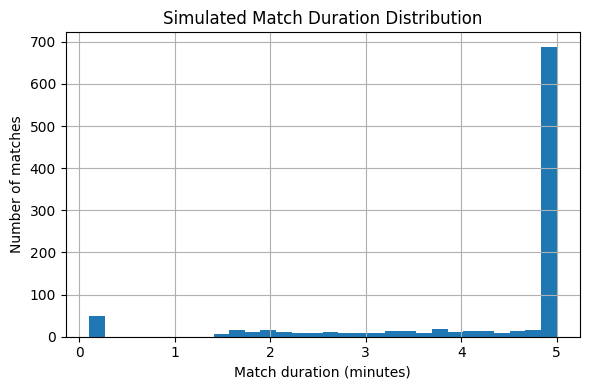

In [103]:
import matplotlib.pyplot as plt

def plot_match_duration_hist(matches):
    plt.figure(figsize=(6,4))
    matches["Duration"].hist(bins=30)
    plt.xlabel("Match duration (minutes)")
    plt.ylabel("Number of matches")
    plt.title("Simulated Match Duration Distribution")
    plt.tight_layout()
    plt.show()

plot_match_duration_hist(matches)

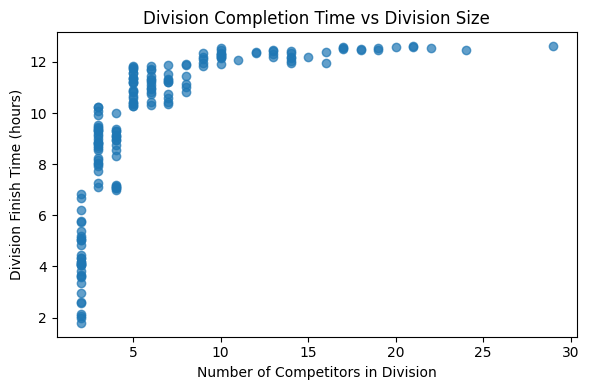

In [104]:
# def plot_division_finish_hist(summary):
#     plt.figure(figsize=(6,4))
#     summary["Finish"].hist(bins=30)
#     plt.xlabel("Division finish time (minutes from env start)")
#     plt.ylabel("Number of divisions")
#     plt.title("Distribution of Division Completion Times")
#     plt.tight_layout()
#     plt.show()

# plot_division_finish_hist(summary)

def plot_division_finish_vs_size(summary):
    plt.figure(figsize=(6,4))
    plt.scatter(summary["Competitors"], summary["Finish"] / 60, alpha=0.7)
    plt.xlabel("Number of Competitors in Division")
    plt.ylabel("Division Finish Time (hours)")
    plt.title("Division Completion Time vs Division Size")
    plt.tight_layout()
    plt.show()

plot_division_finish_vs_size(summary)

In [105]:
def monte_carlo(df, N=100, mats_list=[4,5,6], scenario="D"):
    results = []

    for mats in mats_list:
            durations = []

            for i in range(N):
                out = run_tournament(df, scenario=scenario, num_mats=mats, seed=1000+i)
                dur = out["tournament_finish"]
                durations.append(dur)

            results.append(dict(
                mats=mats,
                durations=durations,           # <--- key addition!
                avg_duration=np.mean(durations),
                p95_duration=np.percentile(durations,95),
            ))

    return results   # now returns a list of dicts, not a DataFrame


In [106]:
df = load_tournament_divisions(CONFIG_FILE)

# Run Monte Carlo across mats + staff
mc = monte_carlo(df, N=100, mats_list=[8, 10, 14])
print(mc)

[{'mats': 8, 'durations': [1309.8223844085455, 1330.6630819541276, 1334.6275849964284, 1327.4684608310915, 1352.0668763189683, 1331.83589106626, 1334.5011386998171, 1331.5616129106932, 1318.8358060616742, 1340.3208479884693, 1355.1956976523047, 1342.437311725981, 1341.9199828897465, 1324.6610185702596, 1317.8898731433524, 1352.9280991116577, 1328.806680304522, 1327.062307150946, 1336.7575648819682, 1347.488609170202, 1337.451977304108, 1348.8707721207807, 1321.0067998576826, 1358.8729071033404, 1320.7640223375968, 1340.2910759319172, 1343.7518372463921, 1352.4301883641454, 1340.3601692702507, 1321.829222504661, 1331.6540771886916, 1348.086961206093, 1333.7541894745352, 1321.8420118936622, 1325.7829852524078, 1348.0042298664823, 1338.4951963271496, 1335.490941170629, 1337.7810022163594, 1344.4415280024714, 1351.1396975062048, 1334.8528025659812, 1338.36636097473, 1345.1605968416604, 1349.874013460049, 1332.2063956399436, 1330.1426635377045, 1313.36877464943, 1347.3909754466972, 1317.959

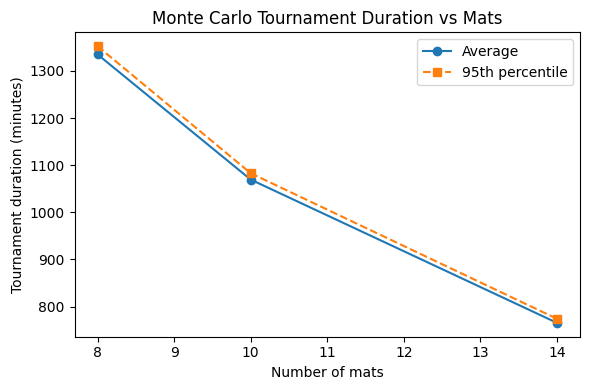

In [107]:
def plot_mc_summary(mc):
    df = pd.DataFrame(mc).sort_values("mats")

    plt.figure(figsize=(6,4))
    plt.plot(df["mats"], df["avg_duration"], marker="o", label="Average")
    plt.plot(df["mats"], df["p95_duration"], marker="s", linestyle="--", label="95th percentile")

    plt.xlabel("Number of mats")
    plt.ylabel("Tournament duration (minutes)")
    plt.title("Monte Carlo Tournament Duration vs Mats")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_mc_summary(mc)

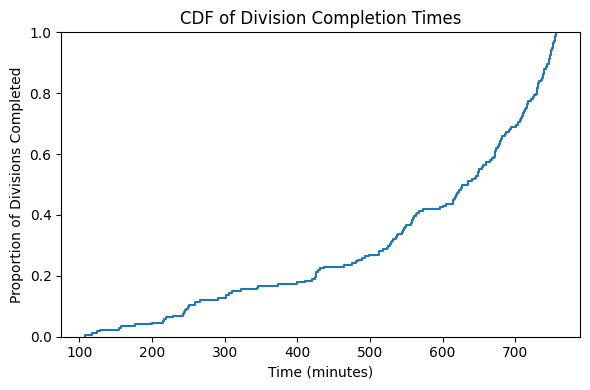

In [108]:
import seaborn as sns
def plot_division_cdf(summary):
    plt.figure(figsize=(6,4))
    sns.ecdfplot(summary["Finish"])
    plt.title("CDF of Division Completion Times")
    plt.xlabel("Time (minutes)")
    plt.ylabel("Proportion of Divisions Completed")
    plt.tight_layout()
    plt.show()

plot_division_cdf(summary)

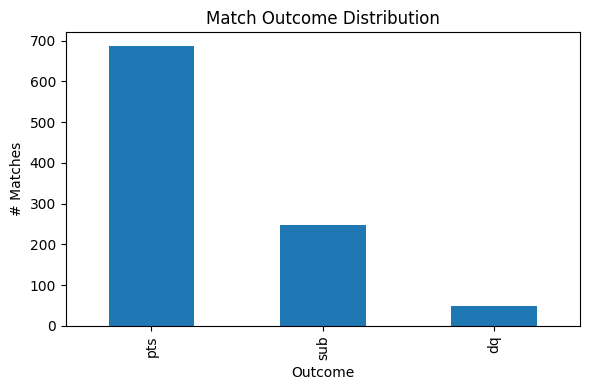

In [109]:
def plot_outcome_distribution(matches):
    plt.figure(figsize=(6,4))
    matches["Outcome"].value_counts().plot(kind="bar")
    plt.title("Match Outcome Distribution")
    plt.xlabel("Outcome")
    plt.ylabel("# Matches")
    plt.tight_layout()
    plt.show()

plot_outcome_distribution(matches)

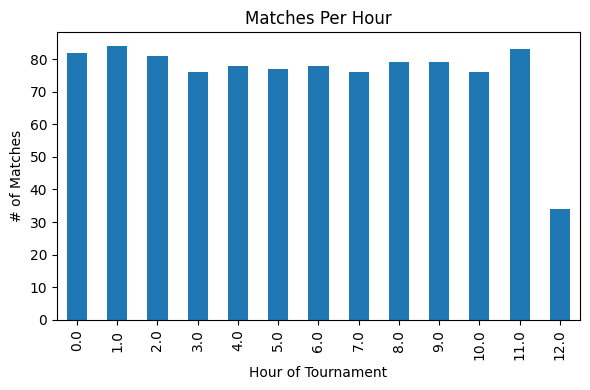

In [110]:
def plot_throughput(matches):
    matches["hour"] = matches["Start"] // 60
    throughput = matches.groupby("hour")["Match"].count()

    plt.figure(figsize=(6,4))
    throughput.plot(kind="bar")
    plt.title("Matches Per Hour")
    plt.xlabel("Hour of Tournament")
    plt.ylabel("# of Matches")
    plt.tight_layout()
    plt.show()

plot_throughput(matches)

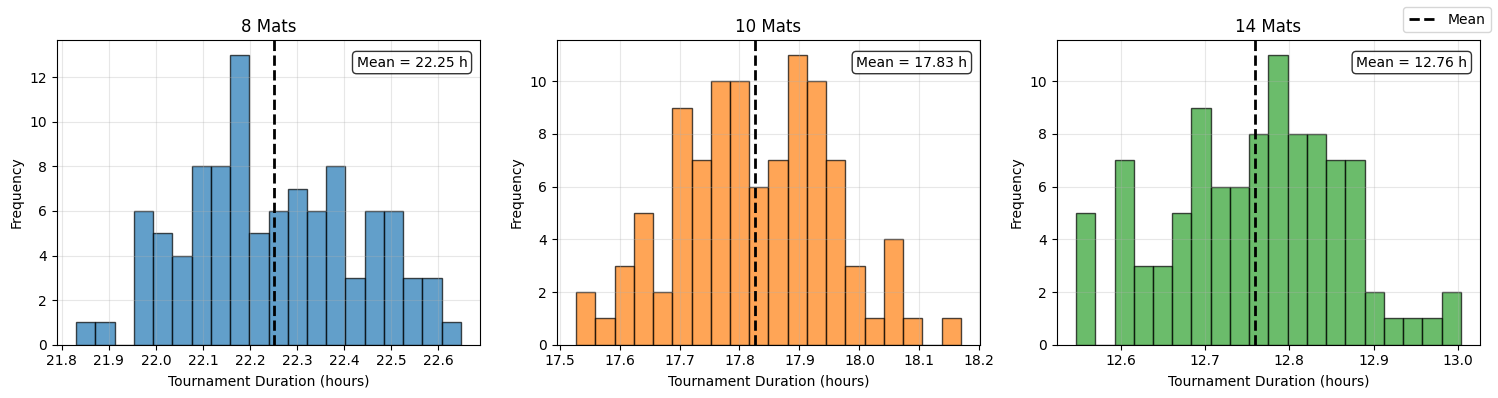

In [111]:
import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt

def plot_mc_hist_grid(results):
    df = pd.DataFrame(results)

    mats_list = sorted(df["mats"].unique())
    palette = sns.color_palette("tab10", n_colors=len(mats_list))
    mat_to_color = dict(zip(mats_list, palette))

    cols = 3
    rows = math.ceil(len(mats_list) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axes = axes.flatten()

    for ax, mats in zip(axes, mats_list):
        durations_min = df[df["mats"] == mats]["durations"].iloc[0]
        durations_hr = np.array(durations_min) / 60

        mean_hr = durations_hr.mean()
        p95_hr = np.percentile(durations_hr, 95)

        ax.hist(
            durations_hr,
            bins=20,
            alpha=0.7,
            edgecolor="black",
            color=mat_to_color[mats]
        )

        # Vertical reference lines
        ax.axvline(mean_hr, color="black", linestyle="--", linewidth=2)

        # Text annotation (top-right inside plot)
        ax.text(
            0.97, 0.95,
            f"Mean = {mean_hr:.2f} h",
            transform=ax.transAxes,
            ha="right",
            va="top",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
        )

        ax.set_title(f"{mats} Mats")
        ax.set_xlabel("Tournament Duration (hours)")
        ax.set_ylabel("Frequency")
        ax.grid(True, alpha=0.3)

    for ax in axes[len(mats_list):]:
        ax.axis("off")

    # Global legend
    fig.legend(
        handles=[
            plt.Line2D([0], [0], color="black", linestyle="--", lw=2, label="Mean")
        ],
        loc="upper right"
    )


    plt.tight_layout()
    plt.show()
plot_mc_hist_grid(mc)